In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. 
it merges two images, namely, a "content" image and a "style" image , to create a "generated" image (G). 
The generated image G combines the "content" of the image C with the "style" of image S

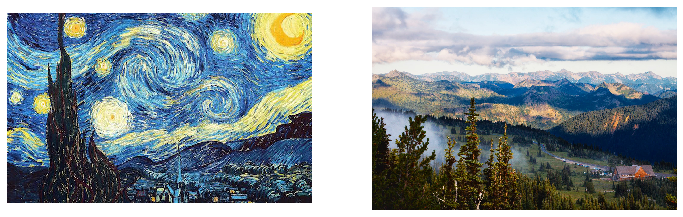

In [2]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.imshow(load_img('./style.jpg'))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(load_img('./content.jpg'))
plt.axis('off')

plt.show()

Following the original NST paper, we will use the VGG-19 network, a 19-layer version of the VGG network. 
This model has already been trained on the very large ImageNet database, 
and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers)

In [3]:
from tensorflow.keras.applications import vgg19

Let's create methods that will allow us to load and preprocess our images easily. 
We perform the same preprocessing process as are expected according to the VGG training process. 
VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.
In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Furthermore, since our optimized image may take its values anywhere between  −∞  and  ∞ , we must clip to maintain our values from within the 0-255 range

In [4]:
def preprocess_img(img_path, img_height=250):
    width, height = load_img(img_path).size
    img_width = int(width * img_height / height)

    img = load_img(img_path, target_size=(img_height, img_width))
    # img.shape = (500, xxxx, 3)
    img = img_to_array(img)

    # img.shape = (1, 500, xxxx, 3)
    img = np.expand_dims(img, axis=0)
    # mean = [103.939, 116.779, 123.68]
    img = vgg19.preprocess_input(img)
    return img

def deprocess_img(img):
    # img.shape == (1, 500, xxx, 3)
    x = img.copy()
    if len(x.shape) == 4:
        # x.shape == (500, xxx, 3)
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x



we will look at some intermediate layers within our model. As we go deeper into the model.
These intermediate layers are necessary to define the representation of content and style from our images. 
For an input image, we will try to match the corresponding style and content target representations at these intermediate layers.

In [5]:
content_layers = [
    'block5_conv2',
]

num_content_layers = len(content_layers)

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1', 
    'block4_conv1', 
    'block5_conv1',
]

num_style_layers = len(style_layers)

In [6]:
from tensorflow.python.keras import models

In [7]:
# build the model
def vgg_layers(layer_names):
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    # frozen the weight
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]

    return models.Model([vgg.input], outputs)

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### Content Loss

So, suppose you have picked one particular hidden layer to use. Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $$a^{(G)}$$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

### Style Loss

Instead of comparing the raw intermediate outputs of the base input image and the style image, we instead compare the Gram matrices of the two outputs. 

Mathematically, we describe the style representation of an image as the correlation between different filter responses given by the Gram matrix  $G^l$, where $G^l_{ij}$ is the inner product (and  represents the correlation) between the vectorized feature map $i$ and $j$ in layer $l$. 

To generate a style for our base input image, we perform gradient descentfrom the content image to transform it into an image that matches the style representation of the original image. We do so by minimizing the mean squared distance between the feature correlation map of the style image and the input image. The contribution $E_l$ of each layer $l$ to the total style loss is described by

$$E_l(m, n) = \frac{1}{4C_l^2D_l^2} \sum_{i,j}(G^l_{ij}(m) - G^l_{ij}(n))^2$$

where $C_l$ is the number of feature maps, each of size $D_l = \textrm{height} \cdot \textrm{width}$. 


In [8]:
def gram_matrix(input_tensor):
    # input_tensor.shape == (500, 800, 64)
    channels = int(input_tensor.shape[-1]) # 64
    # a.shape == (w*h, channels)
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    # gram.shape == (channels, channels)
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def compute_loss(
        style_targets, content_targets, loss_weights, init_img, outputs):
    style_weight, content_weight = loss_weights

    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    total_loss = style_loss + content_loss
    total_loss += total_variation_weight * total_variation_loss(init_img)
    return total_loss, style_loss, content_loss


In [9]:
def compute_gradients(cfg):
    with tf.GradientTape() as tape:
        outputs = cfg['extractor'](cfg['init_img'])
        all_loss = compute_loss(cfg['style_targets'], cfg['content_targets'], cfg['loss_weights'], cfg['init_img'], outputs)
    total_loss, style_loss, content_loss = all_loss

    return tape.gradient(total_loss, cfg['init_img']), all_loss

In [10]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        for layer in self.vgg.layers:
            layer.trainable = False

    def call(self, image):
        preprocessed_input = image
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [12]:
import time
import IPython
from PIL import Image
import IPython.display

In [13]:
def run_style_transfer(content_path, style_path, n_iterations=100,
                       content_weight=1e4, style_weight=1e-4,
                       display_iterations=True):
    extractor = StyleContentModel(style_layers, content_layers)

    style_targets = extractor(preprocess_img(style_path))['style']
    content_targets = extractor(preprocess_img(content_path))['content']

    init_img = preprocess_img(content_path)
    init_img = tf.Variable(init_img, dtype=tf.float32)

    opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'extractor': extractor,
        'loss_weights': loss_weights,
        'init_img': init_img,
        'style_targets': style_targets,
        'content_targets': content_targets
    }


    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(n_iterations):
        print(i)
        start_time = time.time()
        gradients, all_loss = compute_gradients(cfg)
        total_loss, style_loss, content_loss = all_loss
        opt.apply_gradients([(gradients, init_img)])
        clipped = tf.clip_by_value(init_img, min_vals, max_vals)
        init_img.assign(clipped)
        end_time = time.time()

        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_img(init_img.numpy())

        if display_iterations:
            n_rows, n_cols = 2, 5
            display_interval = n_iterations / (n_rows * n_cols)

            if i % display_interval == 0:
                start_time = time.time()

                plot_img = deprocess_img(init_img.numpy())
                imgs.append(plot_img)

                IPython.display.clear_output(wait=True)
                IPython.display.display_png(Image.fromarray(plot_img))


                print('Iteration: %d' % i)
                print(
                    '''Total loss: %.4e,
                      style loss: %.4e,
                      content loss: %.4e, 
                      time: %.4fs''' % (total_loss, style_loss, content_loss,
                                             time.time() - start_time))

    if display_iterations:
        IPython.display.clear_output(wait=True)

        plt.figure(figsize=(14, 4))

        for i, img in enumerate(imgs):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(img)
            plt.axis('off')

        print('Total time: %.4fs' % (time.time() - global_start))

    return best_img, best_loss


Total time: 2977.3600s
69747.22


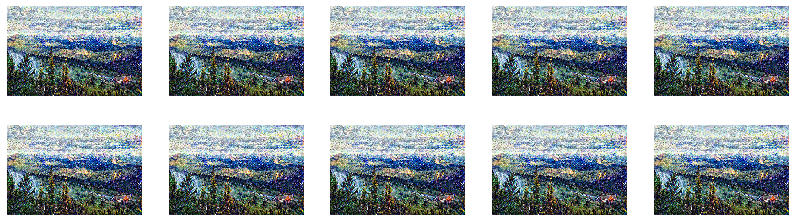

In [14]:
best_img, best_loss = run_style_transfer('./800.png', './style.jpg')
print(best_loss.numpy())

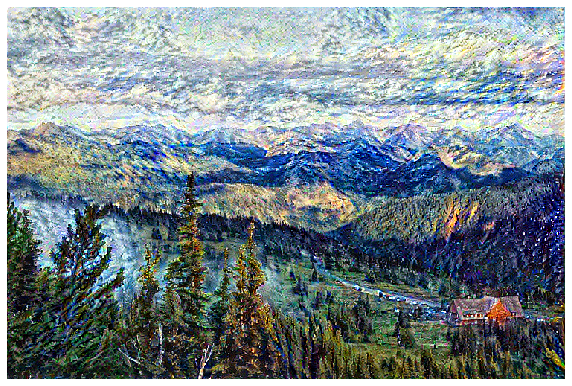

In [15]:
plt.figure(figsize=(10, 10))

plt.imshow(best_img)
plt.axis('off')

plt.show()

In [18]:
plt.imsave('result.png', best_img)